In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Purpose

The purpose of this notebook is to test out collecting the analysis run on the cluster, which saves an analysis file for each epoch.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

Let's try reading in ripple-locked power for all ripples with a 4Hz frequency resolution.

In [9]:
from src.data_processing import read_netcdfs

In [3]:
combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/power',
                        transform_func=None)

combined

<xarray.Dataset>
Dimensions:     (frequency: 188, session: 47, tetrode: 872, time: 5)
Coordinates:
  * tetrode     (tetrode) object 'HPa141' 'HPa1410' 'HPa1411' 'HPa1412' ...
  * frequency   (frequency) float64 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 ...
  * time        (time) float64 -0.625 -0.375 -0.125 0.125 0.375
    brain_area  (session, tetrode) object 'CA1' 'iCA1' 'iCA1' 'iCA1' 'iCA1' ...
Dimensions without coordinates: session
Data variables:
    power       (session, time, frequency, tetrode) float64 16.77 33.04 ...

In [5]:
from functools import partial

def select_brain_areas(dataset, area1='', area2=''):
    if 'tetrode1' in dataset.coords:
        return dataset.sel(
            tetrode1=dataset.tetrode1[dataset.brain_area1==area1],
            tetrode2=dataset.tetrode2[dataset.brain_area2==area2]
        )
    else:
        # The dataset is power
        return dataset.sel(
            tetrode=dataset.tetrode[dataset.brain_area==area1],
        )

CA1_PFC = partial(select_brain_areas, area1='CA1', area2='PFC')

combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/coherence',
                        transform_func=CA1_PFC)

combined

<xarray.Dataset>
Dimensions:              (frequency: 188, session: 47, tetrode1: 282, tetrode2: 319, time: 5)
Coordinates:
  * tetrode1             (tetrode1) object 'HPa141' 'HPa142' 'HPa144' ...
  * tetrode2             (tetrode2) object 'HPa1415' 'HPa1416' 'HPa1417' ...
  * frequency            (frequency) float64 2.0 6.0 10.0 14.0 18.0 22.0 ...
  * time                 (time) float64 -0.625 -0.375 -0.125 0.125 0.375
    brain_area2          (session, tetrode2) object 'PFC' 'PFC' 'PFC' 'PFC' ...
    brain_area1          (session, tetrode1) object 'CA1' 'CA1' 'CA1' 'CA1' ...
Dimensions without coordinates: session
Data variables:
    coherence_magnitude  (session, time, frequency, tetrode1, tetrode2) float64 0.00872 ...

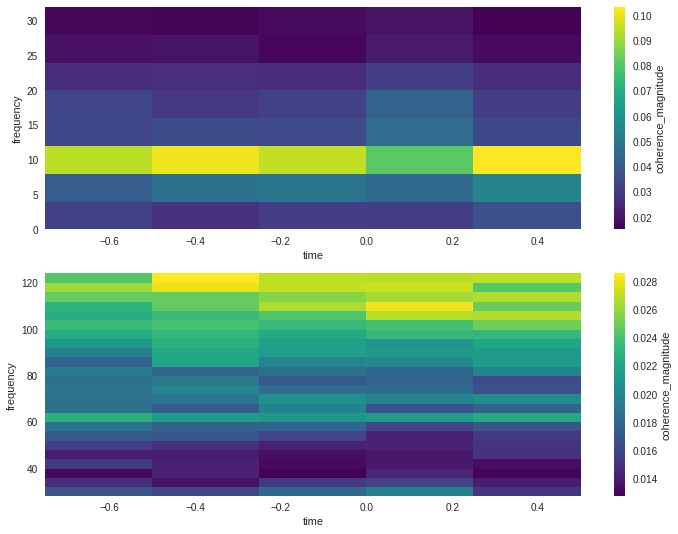

In [54]:
coh = combined.mean(['tetrode1', 'tetrode2', 'session']).coherence_magnitude
fig, axes = plt.subplots(2, 1, figsize=(12, 9))
coh.sel(frequency=slice(0, 30)).plot(x='time', y='frequency', ax=axes[0]);
coh.sel(frequency=slice(30, 125)).plot(x='time', y='frequency', ax=axes[1]);

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


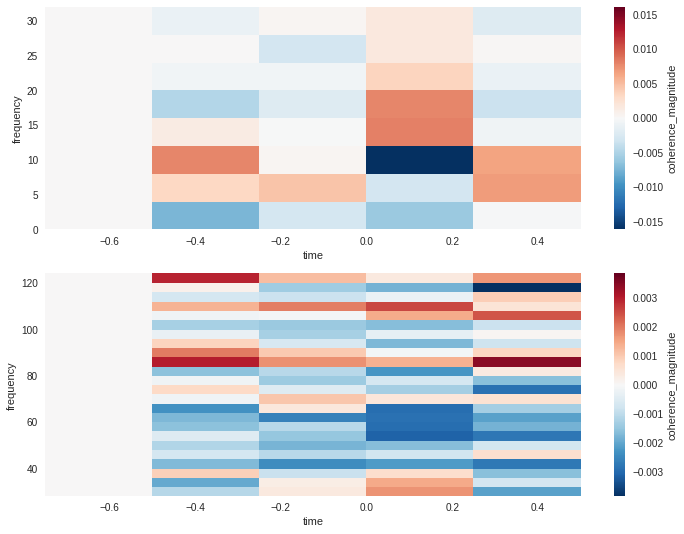

In [14]:
coh_diff = (combined - combined.isel(time=0)).mean(['tetrode1', 'tetrode2', 'session']).coherence_magnitude
fig, axes = plt.subplots(2, 1, figsize=(12, 9))
coh_diff.sel(frequency=slice(0, 30)).plot(x='time', y='frequency', ax=axes[0]);
coh_diff.sel(frequency=slice(30, 125)).plot(x='time', y='frequency', ax=axes[1]);

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


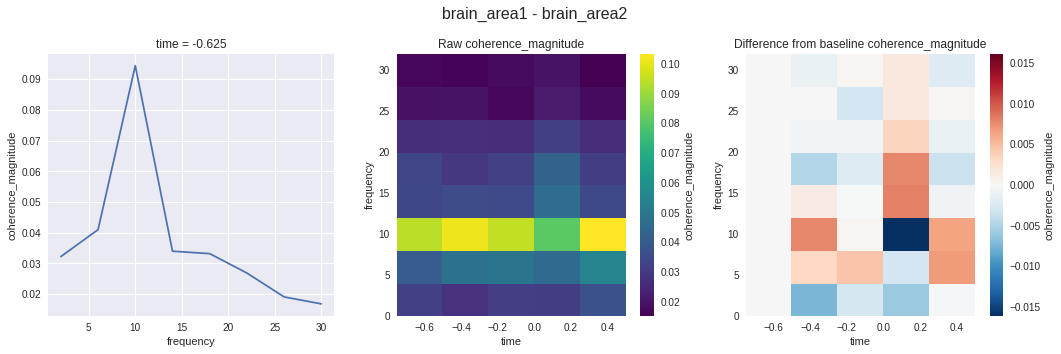

In [6]:
def plot_measure(ds, connectivity_measure,
                 figsize=(15, 5), brain_area1='brain_area1',
                 brain_area2='brain_area2'):
    baseline = ds.isel(time=0)[connectivity_measure].mean(['tetrode1', 'tetrode2', 'session'])
    raw_measure = ds[connectivity_measure].mean(['tetrode1', 'tetrode2', 'session'])
    diff_from_baseline = (ds - ds.isel(time=0)).mean(['tetrode1', 'tetrode2', 'session'])[connectivity_measure]

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    baseline.plot(ax=axes[0]);
    raw_measure.plot(x='time', y='frequency', ax=axes[1]);
    axes[1].set_title(
        'Raw {connectivity_measure}'.format(connectivity_measure=connectivity_measure))
    diff_from_baseline.plot(x='time', y='frequency', ax=axes[2]);
    axes[2].set_title(
    'Difference from baseline {connectivity_measure}'.format(connectivity_measure=connectivity_measure))
    plt.tight_layout()
    plt.suptitle(
        '{brain_area1} - {brain_area2}'.format(
            brain_area1=brain_area1, brain_area2=brain_area2),
        fontsize=16)
    plt.subplots_adjust(top=0.85)
    
plot_measure(combined.sel(frequency=slice(0, 30)), 'coherence_magnitude')

In [7]:
def plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest):

    ds = read_netcdfs(
        '../Processed-Data/*.nc',
        dim='session', group=group,
        transform_func=partial(
            select_brain_areas,
            area1=brain_area1,
            area2=brain_area2)
    )
    plot_measure(
        ds.sel(frequency=frequency_of_interest),
        connectivity_measure,
        brain_area1=brain_area1,
        brain_area2=brain_area2
    )

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


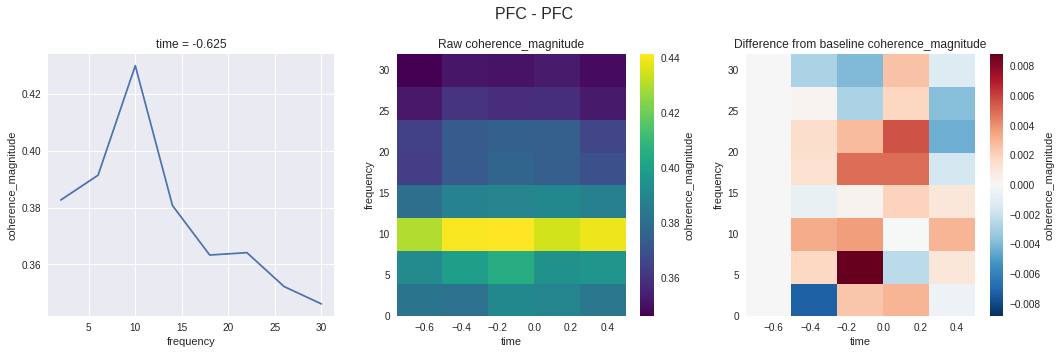

In [41]:
brain_area1 = 'PFC'
brain_area2 = 'PFC'
group = '4Hz_Resolution/all_ripples/coherence'
connectivity_measure = 'coherence_magnitude'
frequency_of_interest = slice(0, 30)

plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


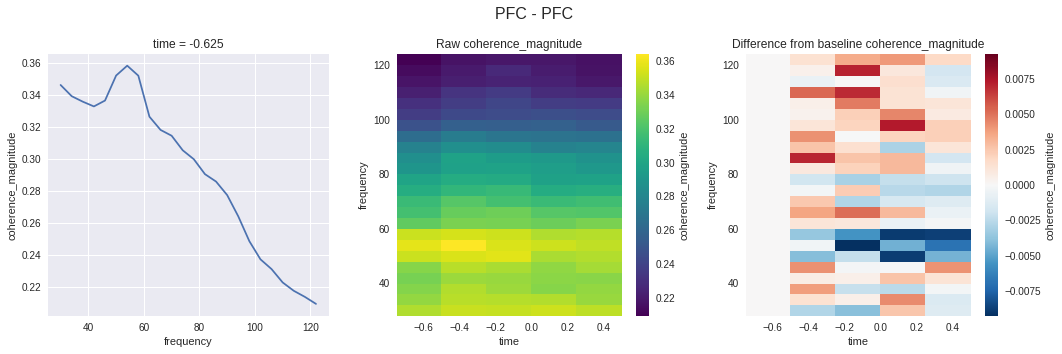

In [42]:
brain_area1 = 'PFC'
brain_area2 = 'PFC'
group = '4Hz_Resolution/all_ripples/coherence'
connectivity_measure = 'coherence_magnitude'
frequency_of_interest = slice(30, 125)

plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


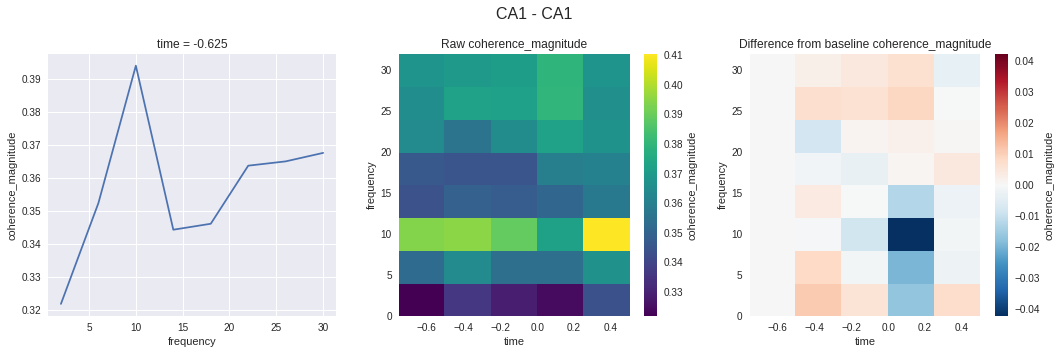

In [44]:
brain_area1 = 'CA1'
brain_area2 = 'CA1'
group = '4Hz_Resolution/all_ripples/coherence'
connectivity_measure = 'coherence_magnitude'
frequency_of_interest = slice(0, 30)

plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


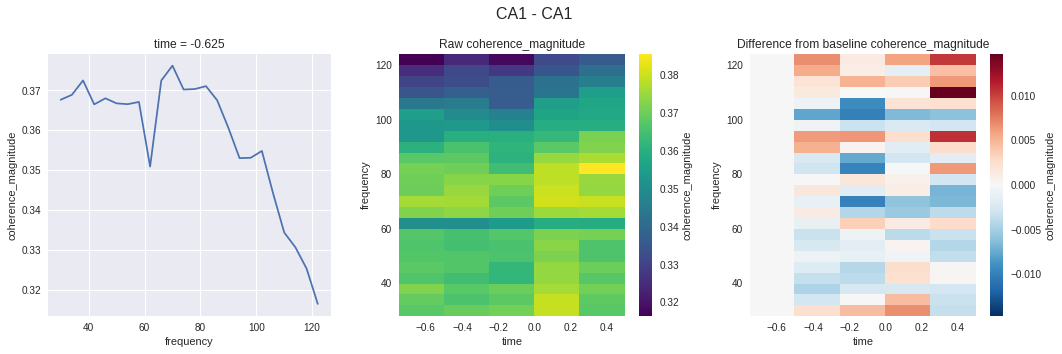

In [45]:
brain_area1 = 'CA1'
brain_area2 = 'CA1'
group = '4Hz_Resolution/all_ripples/coherence'
connectivity_measure = 'coherence_magnitude'
frequency_of_interest = slice(30, 125)

plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


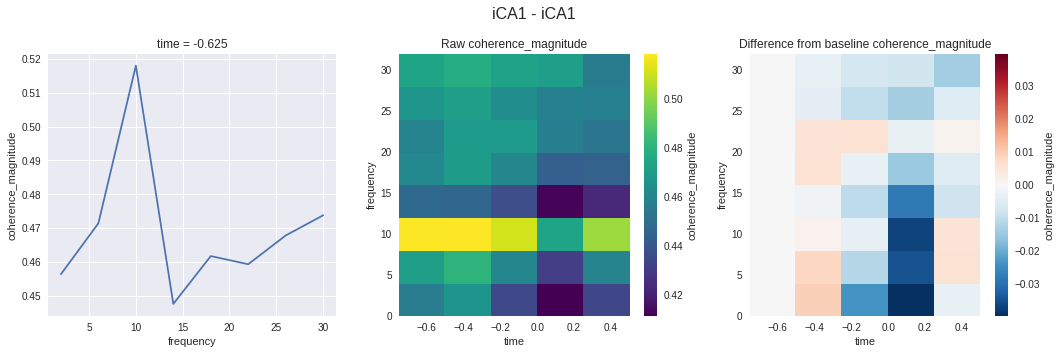

In [16]:
brain_area1 = 'iCA1'
brain_area2 = 'iCA1'
group = '4Hz_Resolution/all_ripples/coherence'
connectivity_measure = 'coherence_magnitude'
frequency_of_interest = slice(0, 30)

plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


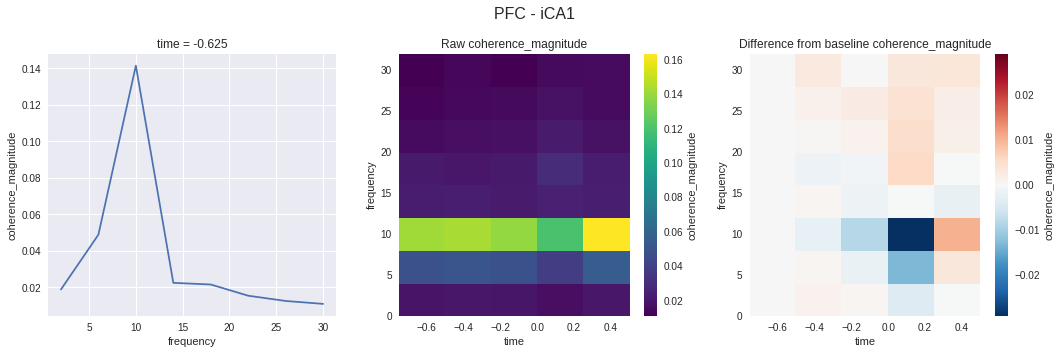

In [17]:
brain_area1 = 'PFC'
brain_area2 = 'iCA1'
group = '4Hz_Resolution/all_ripples/coherence'
connectivity_measure = 'coherence_magnitude'
frequency_of_interest = slice(0, 30)

plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest)

In [47]:
combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/canonical_coherence',
                        transform_func=None)

combined

<xarray.Dataset>
Dimensions:              (brain_area1: 4, brain_area2: 4, frequency: 188, session: 47, time: 5)
Coordinates:
  * brain_area1          (brain_area1) object 'CA1' 'Ctx' 'PFC' 'iCA1'
  * brain_area2          (brain_area2) object 'CA1' 'Ctx' 'PFC' 'iCA1'
  * frequency            (frequency) float64 2.0 6.0 10.0 14.0 18.0 22.0 ...
  * time                 (time) float64 -0.625 -0.375 -0.125 0.125 0.375
Dimensions without coordinates: session
Data variables:
    canonical_coherence  (session, time, frequency, brain_area1, brain_area2) float64 nan ...

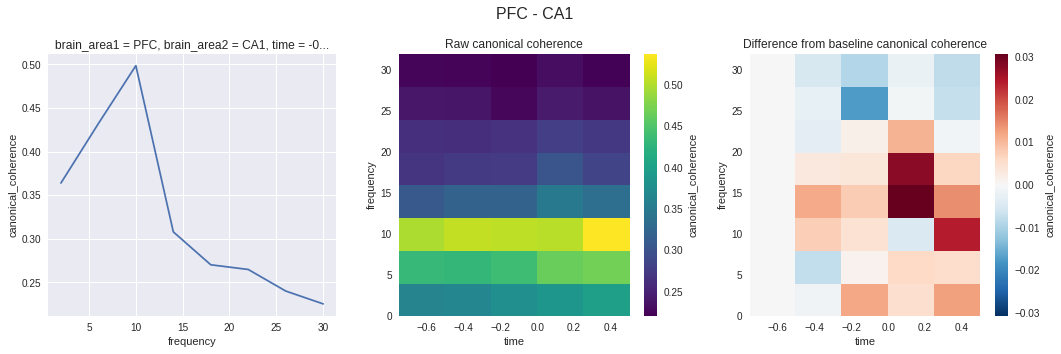

In [56]:
def plot_canonical_coherence(group, brain_area1, brain_area2, frequencies_of_interest, figsize=(15, 5)):
    ds = (
        read_netcdfs(
            '../Processed-Data/*.nc',
            dim='session', group=group)
        .sel(
            brain_area1=brain_area1,
            brain_area2=brain_area2,
            frequency=frequencies_of_interest)
        .canonical_coherence
    )
    
    baseline = ds.isel(time=0).mean('session')
    raw_measure = ds.mean('session')
    diff_from_baseline = (ds - ds.isel(time=0)).mean('session')

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    baseline.plot(ax=axes[0]);
    raw_measure.plot(x='time', y='frequency', ax=axes[1]);
    axes[1].set_title(
        'Raw canonical coherence')
    diff_from_baseline.plot(x='time', y='frequency', ax=axes[2]);
    axes[2].set_title(
        'Difference from baseline canonical coherence')
    plt.tight_layout()
    plt.suptitle(
        '{brain_area1} - {brain_area2}'.format(
            brain_area1=brain_area1, brain_area2=brain_area2),
        fontsize=16)
    plt.subplots_adjust(top=0.85)
    
plot_canonical_coherence('4Hz_Resolution/all_ripples/canonical_coherence', 'PFC', 'CA1', slice(0, 30))

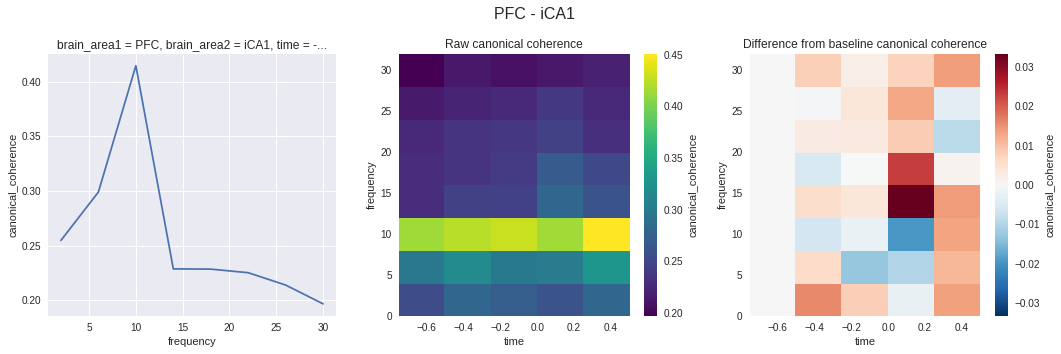

In [57]:
plot_canonical_coherence('4Hz_Resolution/all_ripples/canonical_coherence', 'PFC', 'iCA1', slice(0, 30))

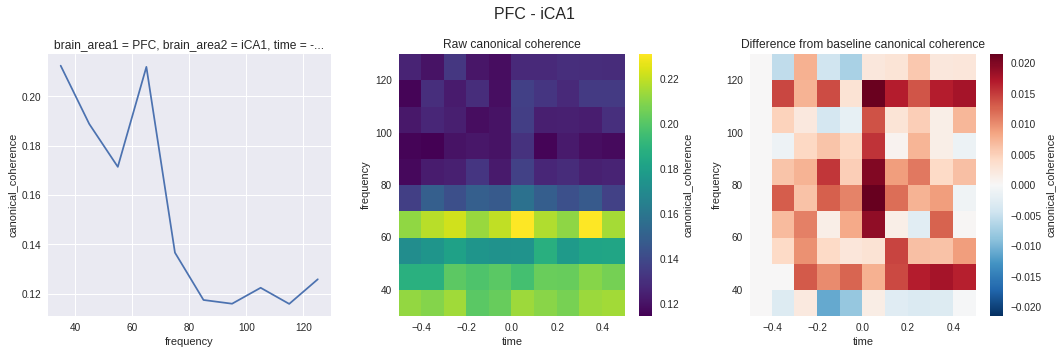

In [61]:
plot_canonical_coherence('10Hz_Resolution/all_ripples/canonical_coherence', 'PFC', 'iCA1', slice(30, 125))

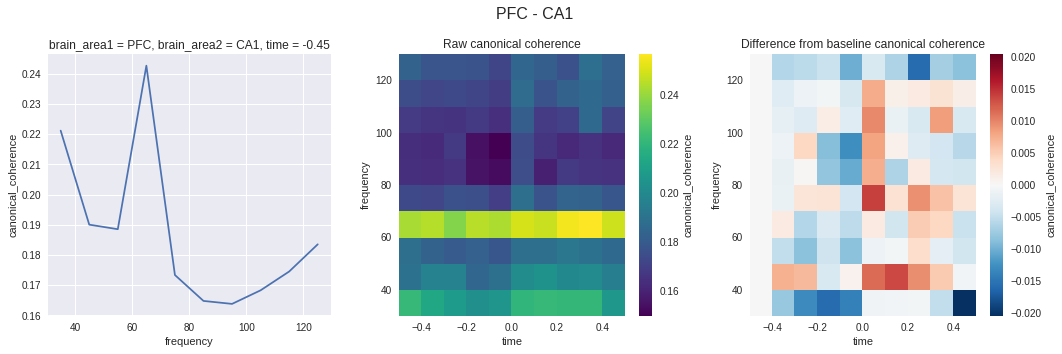

In [60]:
plot_canonical_coherence('10Hz_Resolution/all_ripples/canonical_coherence', 'PFC', 'CA1', slice(30, 125))

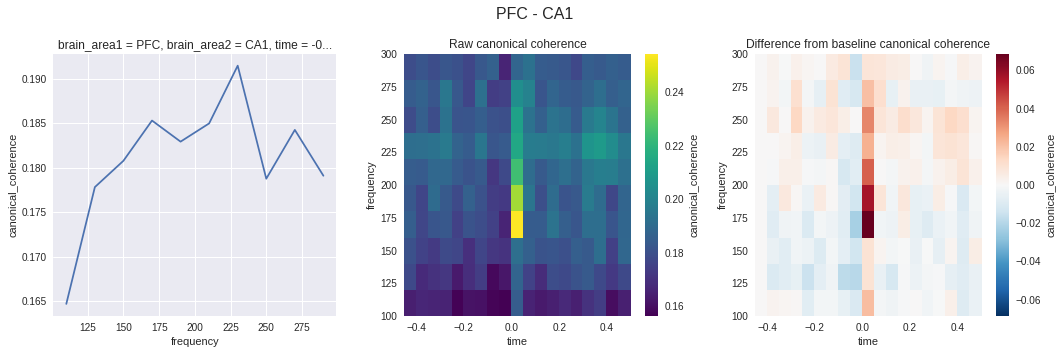

In [62]:
plot_canonical_coherence('20Hz_Resolution/all_ripples/canonical_coherence', 'PFC', 'CA1', slice(100, 300))

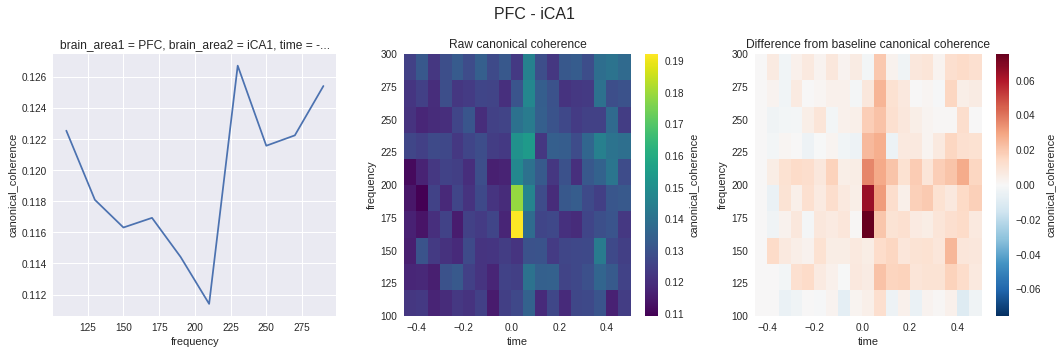

In [63]:
plot_canonical_coherence('20Hz_Resolution/all_ripples/canonical_coherence', 'PFC', 'iCA1', slice(100, 300))

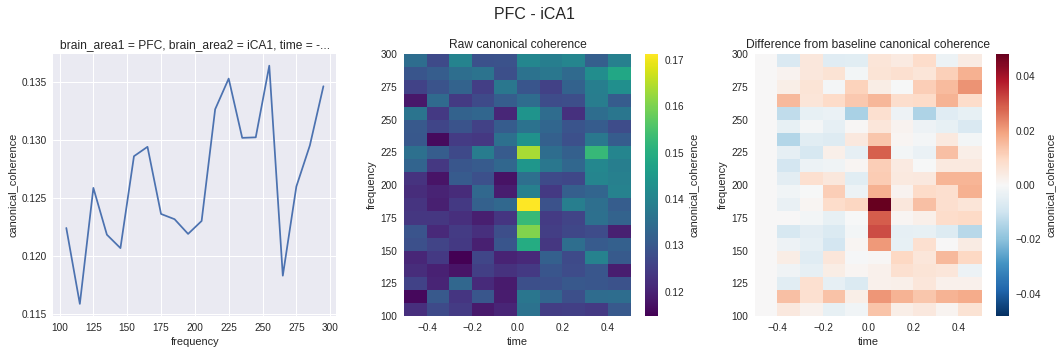

In [64]:
plot_canonical_coherence('10Hz_Resolution/all_ripples/canonical_coherence', 'PFC', 'iCA1', slice(100, 300))

In [65]:
combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/group_delay',
                        transform_func=None)

combined

<xarray.Dataset>
Dimensions:         (frequency_band: 6, session: 47, tetrode1: 872, tetrode2: 872, time: 5)
Coordinates:
  * tetrode2        (tetrode2) object 'HPa141' 'HPa1410' 'HPa1411' 'HPa1412' ...
  * frequency_band  (frequency_band) object 'beta' 'fast_gamma' 'mid_gamma' ...
  * tetrode1        (tetrode1) object 'HPa141' 'HPa1410' 'HPa1411' 'HPa1412' ...
  * time            (time) float64 -0.625 -0.375 -0.125 0.125 0.375
    brain_area2     (session, tetrode2) object 'CA1' 'iCA1' 'iCA1' 'iCA1' ...
    brain_area1     (session, tetrode1) object 'CA1' 'iCA1' 'iCA1' 'iCA1' ...
Dimensions without coordinates: session
Data variables:
    slope           (session, time, frequency_band, tetrode1, tetrode2) float64 1.0 ...
    delay           (session, time, frequency_band, tetrode1, tetrode2) float64 1.0 ...
    r_value         (session, time, frequency_band, tetrode1, tetrode2) float64 1.0 ...

In [67]:
combined.sel(frequency_band='ripple').delay

<xarray.DataArray 'delay' (session: 47, time: 5, tetrode1: 872, tetrode2: 872)>
array([[[[  1., ...,  nan],
         ..., 
         [ nan, ...,  nan]],

        ..., 
        [[  1., ...,  nan],
         ..., 
         [ nan, ...,  nan]]],


       ..., 
       [[[ nan, ...,  nan],
         ..., 
         [ nan, ...,   1.]],

        ..., 
        [[ nan, ...,  nan],
         ..., 
         [ nan, ...,   1.]]]])
Coordinates:
  * tetrode2        (tetrode2) object 'HPa141' 'HPa1410' 'HPa1411' 'HPa1412' ...
    frequency_band  <U6 'ripple'
  * tetrode1        (tetrode1) object 'HPa141' 'HPa1410' 'HPa1411' 'HPa1412' ...
  * time            (time) float64 -0.625 -0.375 -0.125 0.125 0.375
    brain_area2     (session, tetrode2) object 'CA1' 'iCA1' 'iCA1' 'iCA1' ...
    brain_area1     (session, tetrode1) object 'CA1' 'iCA1' 'iCA1' 'iCA1' ...
Dimensions without coordinates: session

In [69]:
from functools import partial

def select_brain_areas(dataset, area1='', area2=''):
    if 'tetrode1' in dataset.coords:
        return dataset.sel(
            tetrode1=dataset.tetrode1[dataset.brain_area1==area1],
            tetrode2=dataset.tetrode2[dataset.brain_area2==area2]
        )
    else:
        # The dataset is power
        return dataset.sel(
            tetrode=dataset.tetrode[dataset.brain_area==area1],
        )

CA1_PFC = partial(select_brain_areas, area1='iCA1', area2='PFC')

combined = read_netcdfs('../Processed-Data/HPa_06_02.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/coherence',
                        transform_func=CA1_PFC)

combined

<xarray.Dataset>
Dimensions:              (frequency: 188, session: 1, tetrode1: 7, tetrode2: 6, time: 5)
Coordinates:
  * tetrode1             (tetrode1) object 'HPa628' 'HPa629' 'HPa6210' ...
  * time                 (time) float64 -0.625 -0.375 -0.125 0.125 0.375
  * tetrode2             (tetrode2) object 'HPa6215' 'HPa6216' 'HPa6217' ...
    brain_area1          (tetrode1) object 'iCA1' 'iCA1' 'iCA1' 'iCA1' ...
  * frequency            (frequency) float64 2.0 6.0 10.0 14.0 18.0 22.0 ...
    brain_area2          (tetrode2) object 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC'
Dimensions without coordinates: session
Data variables:
    coherence_magnitude  (session, time, frequency, tetrode1, tetrode2) float64 0.001456 ...

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


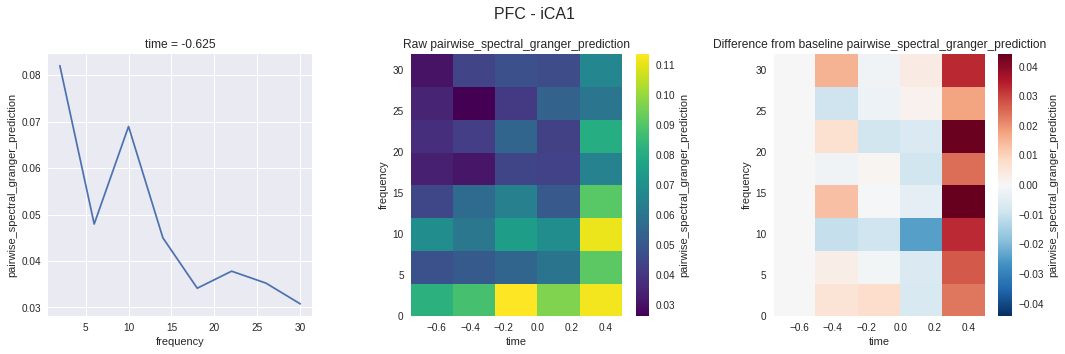

In [18]:
brain_area1 = 'PFC'
brain_area2 = 'iCA1'
group = '4Hz_Resolution/all_ripples/pairwise_spectral_granger_prediction'
connectivity_measure = 'pairwise_spectral_granger_prediction'
frequency_of_interest = slice(0, 30)

plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag_array = (arr1 == arr2)


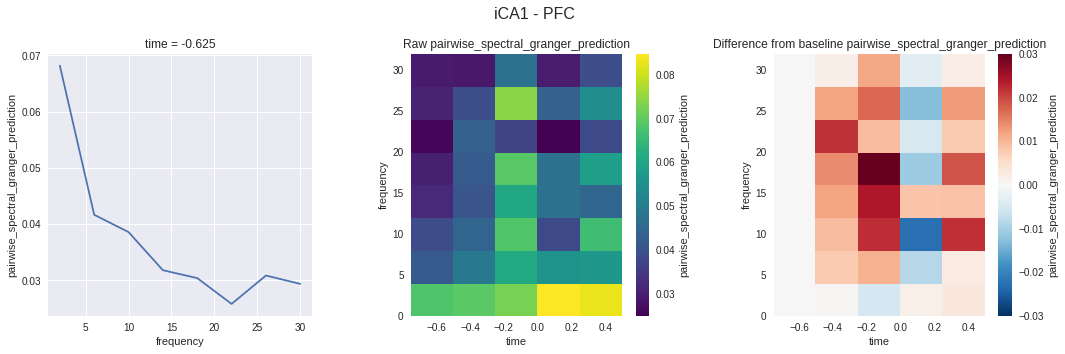

In [19]:
brain_area1 = 'iCA1'
brain_area2 = 'PFC'
group = '4Hz_Resolution/all_ripples/pairwise_spectral_granger_prediction'
connectivity_measure = 'pairwise_spectral_granger_prediction'
frequency_of_interest = slice(0, 30)

plot_connectivity(
    group, brain_area1, brain_area2,
    connectivity_measure, frequency_of_interest)

In [20]:
combined = read_netcdfs('../Processed-Data/HPa_*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/power',
                        transform_func=None)

combined

<xarray.Dataset>
Dimensions:     (frequency: 188, session: 16, tetrode: 304, time: 5)
Coordinates:
  * tetrode     (tetrode) object 'HPa141' 'HPa1410' 'HPa1411' 'HPa1412' ...
  * frequency   (frequency) float64 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 ...
  * time        (time) float64 -0.625 -0.375 -0.125 0.125 0.375
    brain_area  (session, tetrode) object 'CA1' 'iCA1' 'iCA1' 'iCA1' 'iCA1' ...
Dimensions without coordinates: session
Data variables:
    power       (session, time, frequency, tetrode) float64 16.77 33.04 ...

In [21]:
combined = read_netcdfs('../Processed-Data/HPb_*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/power',
                        transform_func=None)

combined

<xarray.Dataset>
Dimensions:     (frequency: 188, session: 16, tetrode: 276, time: 5)
Coordinates:
  * tetrode     (tetrode) object 'HPb141' 'HPb1410' 'HPb1412' 'HPb1413' ...
  * frequency   (frequency) float64 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 ...
  * time        (time) float64 -0.625 -0.375 -0.125 0.125 0.375
    brain_area  (session, tetrode) object 'CA1' 'PFC' 'PFC' 'PFC' 'PFC' ...
Dimensions without coordinates: session
Data variables:
    power       (session, time, frequency, tetrode) float64 29.99 1.122 ...

In [22]:
combined = read_netcdfs('../Processed-Data/*_01_*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/power',
                        transform_func=None)

combined

<xarray.Dataset>
Dimensions:     (frequency: 188, session: 6, tetrode: 114, time: 5)
Coordinates:
  * tetrode     (tetrode) object 'HPa141' 'HPa1410' 'HPa1411' 'HPa1412' ...
  * frequency   (frequency) float64 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 ...
  * time        (time) float64 -0.625 -0.375 -0.125 0.125 0.375
    brain_area  (session, tetrode) object 'CA1' 'iCA1' 'iCA1' 'iCA1' 'iCA1' ...
Dimensions without coordinates: session
Data variables:
    power       (session, time, frequency, tetrode) float64 16.77 33.04 ...

In [23]:
combined.tetrode

<xarray.DataArray 'tetrode' (tetrode: 114)>
array(['HPa141', 'HPa1410', 'HPa1411', 'HPa1412', 'HPa1413', 'HPa1414',
       'HPa1415', 'HPa1416', 'HPa1417', 'HPa1418', 'HPa1419', 'HPa142',
       'HPa1420', 'HPa144', 'HPa145', 'HPa146', 'HPa147', 'HPa148', 'HPa149',
       'HPa161', 'HPa1610', 'HPa1611', 'HPa1612', 'HPa1613', 'HPa1614',
       'HPa1615', 'HPa1616', 'HPa1617', 'HPa1618', 'HPa1619', 'HPa162',
       'HPa1620', 'HPa164', 'HPa165', 'HPa166', 'HPa167', 'HPa168', 'HPa169',
       'HPb141', 'HPb1410', 'HPb1412', 'HPb1413', 'HPb1414', 'HPb1415',
       'HPb1416', 'HPb1417', 'HPb1418', 'HPb1419', 'HPb142', 'HPb1420',
       'HPb143', 'HPb144', 'HPb145', 'HPb146', 'HPb148', 'HPb149', 'HPb161',
       'HPb1610', 'HPb1612', 'HPb1613', 'HPb1614', 'HPb1615', 'HPb1616',
       'HPb1617', 'HPb1618', 'HPb1619', 'HPb162', 'HPb1620', 'HPb163', 'HPb164',
       'HPb165', 'HPb166', 'HPb168', 'HPb169', 'HPc141', 'HPc1410', 'HPc1411',
       'HPc1412', 'HPc1413', 'HPc1414', 'HPc1415', 'HPc141

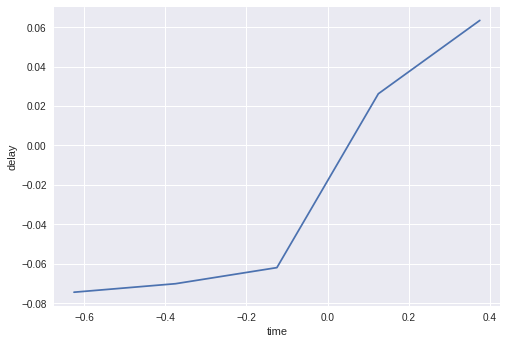

In [29]:
combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/group_delay',
                        transform_func=(
                            lambda ds: ds.sel(
                                tetrode1=ds.tetrode1[ds.brain_area1=='PFC'],
                                tetrode2=ds.tetrode2[ds.brain_area1=='CA1'],
                                frequency_band='beta'))
                       ).mean(['session', 'tetrode1', 'tetrode2'])

combined.delay.plot()

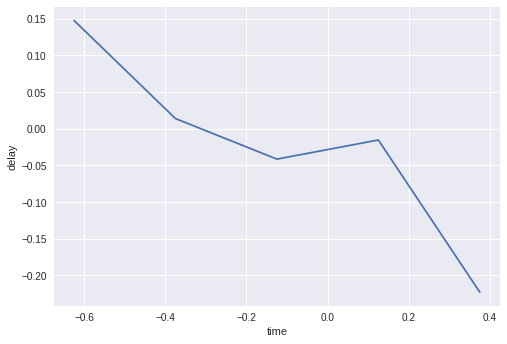

In [30]:
combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/group_delay',
                        transform_func=(
                            lambda ds: ds.sel(
                                tetrode1=ds.tetrode1[ds.brain_area1=='PFC'],
                                tetrode2=ds.tetrode2[ds.brain_area1=='iCA1'],
                                frequency_band='beta'))
                       ).mean(['session', 'tetrode1', 'tetrode2'])

combined.delay.plot()

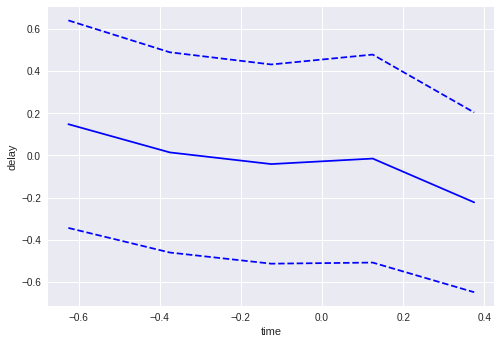

In [37]:
combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/group_delay',
                        transform_func=(
                            lambda ds: ds.sel(
                                tetrode1=ds.tetrode1[ds.brain_area1=='PFC'],
                                tetrode2=ds.tetrode2[ds.brain_area1=='iCA1'],
                                frequency_band='beta'))
                       )

fig, ax = plt.subplots(1,1)

(combined.mean(['session', 'tetrode1', 'tetrode2']).delay +
 combined.var(['session', 'tetrode1', 'tetrode2']).delay
).plot(ax=ax, color='blue', linestyle='--')

(combined.mean(['session', 'tetrode1', 'tetrode2']).delay -
 combined.var(['session', 'tetrode1', 'tetrode2']).delay
).plot(ax=ax, color='blue', linestyle='--')

(combined.mean(['session', 'tetrode1', 'tetrode2']).delay
).plot(ax=ax, color='blue')